In [23]:
import string
import numpy as np
import networkx as nx
import random
import matplotlib
import matplotlib.pyplot as plt
import pycspade
from sequential.seq2pat import Seq2Pat
from gsppy.gsp import GSP
from pprint import pprint
from collections import defaultdict
from itertools import tee

MAX_STATES = 6
N_OF_STATES = 2**MAX_STATES

STATE_MAP = {i: string.ascii_lowercase[i] for i in range(MAX_STATES)}

def pairwise(i):
    a, b = tee(i)
    next(b, None)
    return zip(a, b)


# Choose colormap
cmap = plt.cm.RdBu

# Get the colormap colors
my_cmap = cmap(np.arange(cmap.N))

# Set alpha
my_cmap[:,-1] = np.linspace(0, 1, cmap.N)

# Create new colormap
my_cmap = matplotlib.colors.ListedColormap(my_cmap)


In [25]:
def n_to_base(number: int):
    return [i for i in range(MAX_STATES) if ((number >> i) & 1)]

def state_chain_to_state_list(episodes: list, start_state = 0):
    ret = []
    prev_state = start_state
    for state in episodes:
        ret.append((state, n_to_base(prev_state ^ state), prev_state ^ state))
        prev_state = state
    return ret


def insert_custom_episodes(episodes: list, state_episode_sequence: list, key: callable):
    inserted = 0
    for i, state in enumerate(iter(state_episode_sequence)):
        if key(state):
            for j, item_to_insert in enumerate(episodes):
                state_episode_sequence.insert(j + i + 1, item_to_insert)
            inserted += 1

def to_cspade_format(episodes: list):
    return [
        [i // 20, i % 20, episode]
            for i, (_, episode, change) in enumerate(episodes)
    ]

def to_cspade_format_2(episodes: list):
    return [
        [i // 20, i % 20, episode]
        for i, episode in enumerate(reformat_for_gsp(episodes, max_length=MAX_STATES))
    ]

def to_cspade_format_3(episodes: list):
    return [
        [i // 20, i % 20, episode]
        for i, episode in enumerate(reformat_for_gsp(episodes, max_length=MAX_STATES))
    ]

def reformat_for_cspade(episodes: list):
    state_map = defaultdict(list)
    for state, episode, change in state_chain_to_state_list(episodes):
        state_map[state].append(episode)

    ret = []
    for i, episode_list in enumerate(state_map.values()):
        for j, episode in enumerate(episode_list):
            ret.append((i, j, episode))
    return ret, state_map

def reformat_for_gsp(state_change: list, max_length: int=5) -> list:
    return [state_change[i: i+max_length] for i in range(len(state_change))]

def reformat_for_seq2pat(state_change: list, max_length: int=5) -> list:
    return [[j + 1 for j in state_change[i: i+max_length]] for i in range(len(state_change))]
    

# def generate_random_episode(chance: float):
#     possible_states = list(range(MAX_STATES))
#     episode = []
#     first = True
#     while first or (random.random() > chance and len(possible_states)):
#         pick = random.randint(0, len(possible_states) - 1)
#         episode.append(possible_states[pick])
#         del possible_states[pick]
#         first = False

#     return episode


def generate_random_episode(*_):
    return random.randint(0, N_OF_STATES-1)

In [17]:
random.seed(0x3230)
x = 0
state_episode_sequence = []
for i in range(5_000):
    y = generate_random_episode()
    if x == y:
        continue
    x = y
    state_episode_sequence.append(x)

print(len(state_episode_sequence))
new_states_1 = [4, 12, 28, 60]
lambda_1 = lambda a: a == 0
insert_custom_episodes(new_states_1, state_episode_sequence, lambda_1)

new_states_2 = [62, 30, 14, 6]
lambda_2 = lambda a: a == 126
insert_custom_episodes(new_states_2, state_episode_sequence, lambda_2)

new_states_3 = [60, 124, 125, 127]
lambda_3 = lambda a: a == 44
insert_custom_episodes(new_states_3, state_episode_sequence, lambda_3)

print(len(state_episode_sequence))

print(state_chain_to_state_list(new_states_1))
print(to_cspade_format(state_chain_to_state_list(new_states_1)))

print(state_chain_to_state_list(new_states_2))
print(to_cspade_format(state_chain_to_state_list(new_states_2)))

4923
5615
[(4, [2], 4), (12, [3], 8), (28, [4], 16), (60, [5], 32)]
[[0, 0, [2]], [0, 1, [3]], [0, 2, [4]], [0, 3, [5]]]
[(62, [1, 2, 3, 4, 5], 62), (30, [5], 32), (14, [4], 16), (6, [3], 8)]
[[0, 0, [1, 2, 3, 4, 5]], [0, 1, [5]], [0, 2, [4]], [0, 3, [3]]]


In [18]:
print(state_episode_sequence[:5])
print(state_chain_to_state_list(state_episode_sequence[:5]))
print(to_cspade_format(state_chain_to_state_list(state_episode_sequence[:5])))

[28, 2, 1, 51, 20]
[(28, [2, 3, 4], 28), (2, [1, 2, 3, 4], 30), (1, [0, 1], 3), (51, [1, 4, 5], 50), (20, [0, 1, 2, 5], 39)]
[[0, 0, [2, 3, 4]], [0, 1, [1, 2, 3, 4]], [0, 2, [0, 1]], [0, 3, [1, 4, 5]], [0, 4, [0, 1, 2, 5]]]


In [19]:
graph = nx.DiGraph()
for (state_old, *_), (state, *_) in pairwise(state_chain_to_state_list(state_episode_sequence)):
    edge = (state_old, state)
    if edge in graph.edges:
        graph.edges[edge]["count"] += 1
    else:
        graph.add_edge(*edge, count=1)


edges, weights = zip(*nx.get_edge_attributes(graph,'count').items())
layout = nx.layout.spring_layout(graph)

{'count': 89}

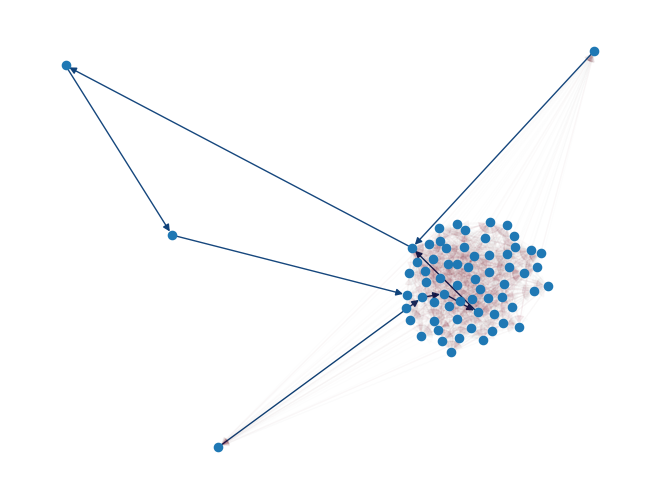

In [20]:
nx.draw(graph, layout, edgelist=edges, edge_color=weights, edge_cmap=my_cmap, node_size=35)
max((graph.edges[i] for i in graph.edges), key=lambda a: a['count'])

In [21]:
result = GSP(reformat_for_gsp(state_episode_sequence, 2)).search(0.03)
pprint(result)

[{(0,): 435,
  (1,): 359,
  (2,): 345,
  (3,): 353,
  (4,): 749,
  (5,): 357,
  (6,): 394,
  (7,): 334,
  (8,): 367,
  (9,): 301,
  (10,): 358,
  (11,): 380,
  (12,): 775,
  (13,): 352,
  (14,): 399,
  (15,): 414,
  (16,): 358,
  (17,): 324,
  (18,): 399,
  (19,): 371,
  (20,): 379,
  (21,): 394,
  (22,): 400,
  (23,): 365,
  (24,): 456,
  (25,): 357,
  (26,): 406,
  (27,): 426,
  (28,): 848,
  (29,): 371,
  (30,): 357,
  (31,): 384,
  (32,): 443,
  (33,): 405,
  (34,): 398,
  (35,): 369,
  (36,): 388,
  (37,): 394,
  (38,): 431,
  (39,): 371,
  (40,): 351,
  (41,): 333,
  (42,): 417,
  (43,): 367,
  (44,): 430,
  (45,): 434,
  (46,): 390,
  (47,): 383,
  (48,): 331,
  (49,): 313,
  (50,): 440,
  (51,): 357,
  (52,): 317,
  (53,): 364,
  (54,): 328,
  (55,): 429,
  (56,): 386,
  (57,): 407,
  (58,): 352,
  (59,): 380,
  (60,): 1270,
  (61,): 392,
  (62,): 324,
  (63,): 378,
  (124,): 430,
  (125,): 430,
  (127,): 430},
 {(0, 4): 348,
  (4, 12): 352,
  (12, 28): 356,
  (28, 60): 356,
  

In [8]:
data, map = reformat_for_cspade(state_episode_sequence)
result = pycspade.spade(data=data, maxsize=MAX_STATES, support=0.9)
pycspade.helpers.print_result(result)

   Occurs     Accum   Support    Confid      Lift                                                                         Sequence
       65     14658 0.9701493       N/A       N/A                                                                              (0) 
       65      2366 0.9701493 1.0000000 1.0307692                                                                         (0)->(0) 
       65       436 0.9701493 1.0000000 1.0307692                                                                    (0)->(0)->(0) 
       62        62 0.9253731 0.9538462 0.9831953                                                               (0)->(0)->(0)->(0) 
       63        63 0.9402985 0.9692308 1.0146635                                                               (0)->(0)->(0)->(3) 
       62        62 0.9253731 0.9538462 0.9985577                                                               (0)->(0)->(0)->(4) 
       61        61 0.9104478 0.9384615 0.9824519                            

In [38]:
result = pycspade.spade(data=to_cspade_format_2(state_episode_sequence), support=0.3, maxlen=MAX_STATES)
pycspade.helpers.print_result(result)

   Occurs     Accum   Support    Confid      Lift                                                                         Sequence
       97       708 0.3451957       N/A       N/A                                                                              (0) 
       92       177 0.3274021 0.9484536 2.7475821                                                                         (0)->(0) 
       85        85 0.3024911 0.9239130 2.6764904                                                                    (0)->(0)->(0) 
       88        88 0.3131673 0.9565217 1.7453416                                                                   (0)->(0)->(12) 
       85        85 0.3024911 0.9659091 1.7624705                                                             (0)->(0)->(12)->(12) 
       85        85 0.3024911 0.9659091 1.7178510                                                             (0)->(0)->(12)->(28) 
       86        86 0.3060498 0.9347826 1.6624931                            

In [10]:
to_cspade_format_2(state_episode_sequence[:100])

[[0, 0, [28, 2, 1, 51, 20]],
 [0, 1, [2, 1, 51, 20, 4]],
 [0, 2, [1, 51, 20, 4, 41]],
 [0, 3, [51, 20, 4, 41, 11]],
 [0, 4, [20, 4, 41, 11, 52]],
 [0, 5, [4, 41, 11, 52, 58]],
 [0, 6, [41, 11, 52, 58, 60]],
 [0, 7, [11, 52, 58, 60, 46]],
 [0, 8, [52, 58, 60, 46, 1]],
 [0, 9, [58, 60, 46, 1, 23]],
 [0, 10, [60, 46, 1, 23, 48]],
 [0, 11, [46, 1, 23, 48, 28]],
 [0, 12, [1, 23, 48, 28, 10]],
 [0, 13, [23, 48, 28, 10, 37]],
 [0, 14, [48, 28, 10, 37, 7]],
 [0, 15, [28, 10, 37, 7, 63]],
 [0, 16, [10, 37, 7, 63, 13]],
 [0, 17, [37, 7, 63, 13, 0]],
 [0, 18, [7, 63, 13, 0, 4]],
 [0, 19, [63, 13, 0, 4, 12]],
 [1, 0, [13, 0, 4, 12, 28]],
 [1, 1, [0, 4, 12, 28, 60]],
 [1, 2, [4, 12, 28, 60, 38]],
 [1, 3, [12, 28, 60, 38, 48]],
 [1, 4, [28, 60, 38, 48, 0]],
 [1, 5, [60, 38, 48, 0, 4]],
 [1, 6, [38, 48, 0, 4, 12]],
 [1, 7, [48, 0, 4, 12, 28]],
 [1, 8, [0, 4, 12, 28, 60]],
 [1, 9, [4, 12, 28, 60, 47]],
 [1, 10, [12, 28, 60, 47, 29]],
 [1, 11, [28, 60, 47, 29, 35]],
 [1, 12, [60, 47, 29, 35, 50]],
 [1,

In [35]:
reformat_for_gsp(state_episode_sequence)

[[28, 2, 1, 51, 20],
 [2, 1, 51, 20, 4],
 [1, 51, 20, 4, 41],
 [51, 20, 4, 41, 11],
 [20, 4, 41, 11, 52],
 [4, 41, 11, 52, 58],
 [41, 11, 52, 58, 60],
 [11, 52, 58, 60, 46],
 [52, 58, 60, 46, 1],
 [58, 60, 46, 1, 23],
 [60, 46, 1, 23, 48],
 [46, 1, 23, 48, 28],
 [1, 23, 48, 28, 10],
 [23, 48, 28, 10, 37],
 [48, 28, 10, 37, 7],
 [28, 10, 37, 7, 63],
 [10, 37, 7, 63, 13],
 [37, 7, 63, 13, 0],
 [7, 63, 13, 0, 4],
 [63, 13, 0, 4, 12],
 [13, 0, 4, 12, 28],
 [0, 4, 12, 28, 60],
 [4, 12, 28, 60, 38],
 [12, 28, 60, 38, 48],
 [28, 60, 38, 48, 0],
 [60, 38, 48, 0, 4],
 [38, 48, 0, 4, 12],
 [48, 0, 4, 12, 28],
 [0, 4, 12, 28, 60],
 [4, 12, 28, 60, 47],
 [12, 28, 60, 47, 29],
 [28, 60, 47, 29, 35],
 [60, 47, 29, 35, 50],
 [47, 29, 35, 50, 36],
 [29, 35, 50, 36, 57],
 [35, 50, 36, 57, 31],
 [50, 36, 57, 31, 26],
 [36, 57, 31, 26, 8],
 [57, 31, 26, 8, 56],
 [31, 26, 8, 56, 43],
 [26, 8, 56, 43, 23],
 [8, 56, 43, 23, 16],
 [56, 43, 23, 16, 24],
 [43, 23, 16, 24, 19],
 [23, 16, 24, 19, 43],
 [16, 24, 

In [26]:
s2p = Seq2Pat(sequences=reformat_for_seq2pat(state_episode_sequence))

In [33]:
s2p.get_patterns(300)

[[29, 61, 376],
 [13, 29, 366],
 [5, 13, 356],
 [1, 5, 348],
 [45, 61, 344],
 [61, 125, 344],
 [125, 126, 344],
 [126, 128, 344]]

In [34]:
reformat_for_seq2pat(state_episode_sequence)

[[29, 3, 2, 52, 21],
 [3, 2, 52, 21, 5],
 [2, 52, 21, 5, 42],
 [52, 21, 5, 42, 12],
 [21, 5, 42, 12, 53],
 [5, 42, 12, 53, 59],
 [42, 12, 53, 59, 61],
 [12, 53, 59, 61, 47],
 [53, 59, 61, 47, 2],
 [59, 61, 47, 2, 24],
 [61, 47, 2, 24, 49],
 [47, 2, 24, 49, 29],
 [2, 24, 49, 29, 11],
 [24, 49, 29, 11, 38],
 [49, 29, 11, 38, 8],
 [29, 11, 38, 8, 64],
 [11, 38, 8, 64, 14],
 [38, 8, 64, 14, 1],
 [8, 64, 14, 1, 5],
 [64, 14, 1, 5, 13],
 [14, 1, 5, 13, 29],
 [1, 5, 13, 29, 61],
 [5, 13, 29, 61, 39],
 [13, 29, 61, 39, 49],
 [29, 61, 39, 49, 1],
 [61, 39, 49, 1, 5],
 [39, 49, 1, 5, 13],
 [49, 1, 5, 13, 29],
 [1, 5, 13, 29, 61],
 [5, 13, 29, 61, 48],
 [13, 29, 61, 48, 30],
 [29, 61, 48, 30, 36],
 [61, 48, 30, 36, 51],
 [48, 30, 36, 51, 37],
 [30, 36, 51, 37, 58],
 [36, 51, 37, 58, 32],
 [51, 37, 58, 32, 27],
 [37, 58, 32, 27, 9],
 [58, 32, 27, 9, 57],
 [32, 27, 9, 57, 44],
 [27, 9, 57, 44, 24],
 [9, 57, 44, 24, 17],
 [57, 44, 24, 17, 25],
 [44, 24, 17, 25, 20],
 [24, 17, 25, 20, 44],
 [17, 25, 